In [1]:
%matplotlib inline

import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import scanpy as sc

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1#0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

In [2]:
# load old data
adata = sc.read('/home/ngr4/project/scnd/data/processed/mouse_210726.h5ad')

In [7]:
# aesthetics
cmap_ctype={'Granule cell': '#FAC18A',
            'Unipolar brush cell': '#BA61BA',
            'Purkinje cell': '#EE5264',
            'GABAergic interneuron 1': '#F9EBAE',
            'GABAergic interneuron 2': '#88BB92',
            'GABAergic interneuron 3': '#46A928',
            'Astrocyte': '#F9AEAE',
            'Bergmann glia': '#AEB7F9',
            'Oligodendrocyte progenitor cell': '#F1815F',
            'Oligodendrocyte': '#75A3B7',
            'Microglia': '#AC5861',
            'Pericyte': '#2D284B',
            'Endothelial cell': '#1C67EE',
            'Deep cerebellar nuclei': '#aaaaaa'}

In [4]:
pfp = '/home/ngr4/project/scnd/results/'

savefigs = True

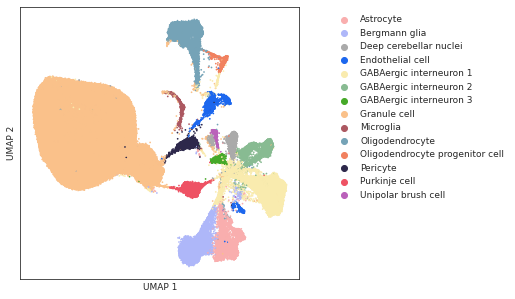

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=adata.obsm['X_umap'][:, 0],
                y=adata.obsm['X_umap'][:, 1],
                hue=adata.obs['ctype_ubcupdate'],
                linewidth=0,
                s=3,
                palette=cmap_ctype,
                rasterized=True)
ax.legend(bbox_to_anchor=(1.1, 1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

if savefigs:
    fig.savefig(os.path.join(pfp, 'umap_mouse_updated_ctypes.pdf'), bbox_inches='tight', dpi=600)
    savefigs = False

In [ ]:
savefigs = True

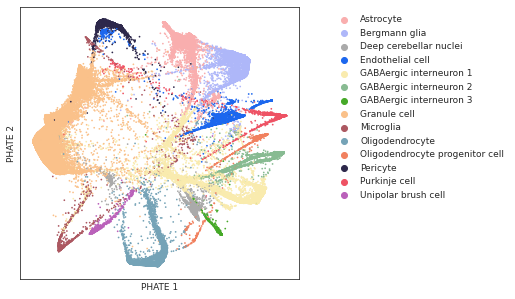

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=adata.obsm['X_phate'][:, 0],
                y=adata.obsm['X_phate'][:, 1],
                hue=adata.obs['ctype_ubcupdate'],
                linewidth=0,
                s=3,
                palette=cmap_ctype,
                rasterized=True)
ax.legend(bbox_to_anchor=(1.1, 1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PHATE 1')
ax.set_ylabel('PHATE 2')

if savefigs:
    fig.savefig(os.path.join(pfp, 'phate_mouse_updated_ctypes.pdf'), bbox_inches='tight', dpi=600)
    savefigs = False

# color by goi

In [2]:
# load imputed data
def imp_goi_to_adata(adata, goi, return_imputed_adatas=False, **kwargs):
    '''Add imputed expression to adata.obs metadata for plotting.
    
    Assumes indices match in adata, wt, and mut.
    
    Arguments:
      adata (sc.AnnData)
      goi (list)
      
    Returns:
      adata: copy of adata with genes of interest imputed expression in adata.obs column with Gene (imputed)
    '''
    if not 'wt' in kwargs:
        wt = sc.read('/home/ngr4/project/scnd/data/processed/mouse_wt_imputed.h5ad')
    else:
        wt = kwargs['wt']
    if not 'mut' in kwargs:
        # option to not supply both
        mut = sc.read('/home/ngr4/project/scnd/data/processed/mouse_sca1_imputed.h5ad')
    else:
        mut = kwargs['mut']
    
    for i, g in enumerate(goi):
        wt.obs['{} (imputed)'.format(g)] = np.asarray(wt[:, g].layers['imputed']).flatten()
        mut.obs['{} (imputed)'.format(g)] = np.asarray(mut[:, g].layers['imputed']).flatten()
        adata.obs = adata.obs.merge(wt.obs['{} (imputed)'.format(g)].append(mut.obs['{} (imputed)'.format(g)]), 
                                    how='left', left_index=True, right_index=True)
    
    if return_imputed_adatas:
        return adata, wt, mut
    else:
        return adata
    
def load_mouse_imputed(key_layer_slot='imputed', **kwargs, ):
    '''Replace sc.AnnData.X slot with scAnnData.layers['imputed']
    '''
    # load imputed data
    if not 'wt' in kwargs:
        wt = sc.read('/home/ngr4/project/scnd/data/processed/mouse_wt_imputed.h5ad')
    else:
        wt = kwargs['wt']    
    if key_layer_slot is not None:
        wt = sc.AnnData(X=wt.layers[key_layer_slot], obs=wt.obs, var=wt.var)
    if not 'mut' in kwargs:
        # option to not supply both
        mut = sc.read('/home/ngr4/project/scnd/data/processed/mouse_sca1_imputed.h5ad')
    else:
        mut = kwargs['mut']
    if key_layer_slot is not None:
        mut = sc.AnnData(X=mut.layers[key_layer_slot], obs=mut.obs, var=mut.var)
    adata = wt.concatenate(mut, batch_key='imp_source', index_unique=None)
    del wt, mut
    if 'add_md' in kwargs:
        adata.obs = adata.obs.merge(kwargs['add_md'], left_index=True, right_index=True)
    return adata


def load_md(file='/home/ngr4/project/scnd/results/adata.obs_210726.csv', colkey='ctype_ubcupdate'):
    return pd.read_csv(file, index_col=0)[colkey]

In [6]:
adata = imp_goi_to_adata(adata, ['Eomes'], return_imputed_adatas=False)

In [25]:
savefigs  = True
wcbar = True
g = 'Eomes'

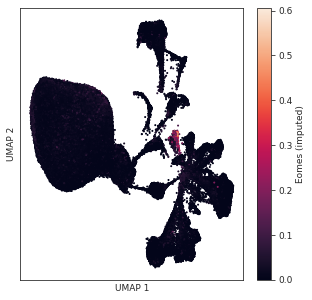

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im = ax.scatter(adata.obsm['X_umap'][:, 0],
           adata.obsm['X_umap'][:, 1], 
           c=adata.obs['{} (imputed)'.format(g)], 
           s=1, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

if wcbar:
    cbar = fig.colorbar(im)
    cbar.set_label('{} expression (imputed)'.format(g))
    
if savefigs:
    if wcbar:
        fig.savefig(os.path.join(pfp, 'umap_mouse_Eomes_imp_cbar.pdf'), bbox_inches='tight', dpi=600)
    else:
        fig.savefig(os.path.join(pfp, 'umap_mouse_Eomes_imp.pdf'), bbox_inches='tight', dpi=600)
    savefigs = False

# violin plots 

In [3]:
mousemarkers = {'Granule cell':['Gabra6','Slc17a7'],
                'Unipolar brush cell':['Slc17a6','Eomes'],
                'Deep cerebellar nuclei': 'Slc17a6',
                'Purkinje cell':['Atp2a3','Calb1','Car8','Ppp1r17','Slc1a6'],
                'Inhibitory interneuron':['Gad1','Gad2','Ntn1','Megf10'],
                'Astrocyte':['Aldh1l1','Aqp4'],
                'Bergmann glia':['Gdf10','Hopx'],
                'OPC':['Olig1','Olig2','Pdgfra'],
                'OL':['Hapln2','Mag','Mog','Opalin'],
                'Microglia':['C1qb','Cx3cr1','Dock2','P2ry12'],
                'Pericytes':['Flt1','Rgs5'],
                'Endothelial cell':['Dcn','Lum','Kdr'],
               }

In [4]:
adata = load_mouse_imputed(add_md=load_md())

                        batch genotype timepoint  n_genes_by_counts  \
AAACCCAAGAGTGGCT-1-7202  7202       WT       5wk               2238   
AAACCCAAGCAAACAT-1-7202  7202       WT       5wk                657   
AAACCCACAGAGGAAA-1-7202  7202       WT       5wk               2132   
AAACCCACAGCGTTGC-1-7202  7202       WT       5wk               4502   
AAACCCACATCGCTCT-1-7202  7202       WT       5wk               1734   

                         log1p_n_genes_by_counts  total_counts  \
AAACCCAAGAGTGGCT-1-7202                 7.713785        4906.0   
AAACCCAAGCAAACAT-1-7202                 6.489205         899.0   
AAACCCACAGAGGAAA-1-7202                 7.665285        4031.0   
AAACCCACAGCGTTGC-1-7202                 8.412499       14456.0   
AAACCCACATCGCTCT-1-7202                 7.458763        3383.0   

                         log1p_total_counts  pct_counts_in_top_50_genes  \
AAACCCAAGAGTGGCT-1-7202            8.498418                   30.554423   
AAACCCAAGCAAACAT-1-7202   

In [16]:
sc.settings.figdir = '/home/ngr4/project/scnd/results/'

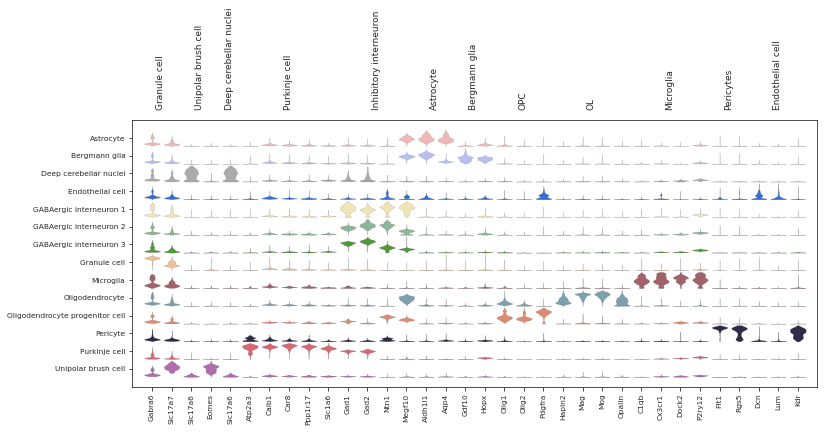

In [17]:
sc.pl.stacked_violin(adata, mousemarkers, groupby='ctype_ubcupdate', 
                     use_raw=False, standard_scale='var',
                     row_palette=[cmap_ctype[i] for i in sorted(cmap_ctype.keys())],
                     save='_fig1update_mouse_violin.pdf')

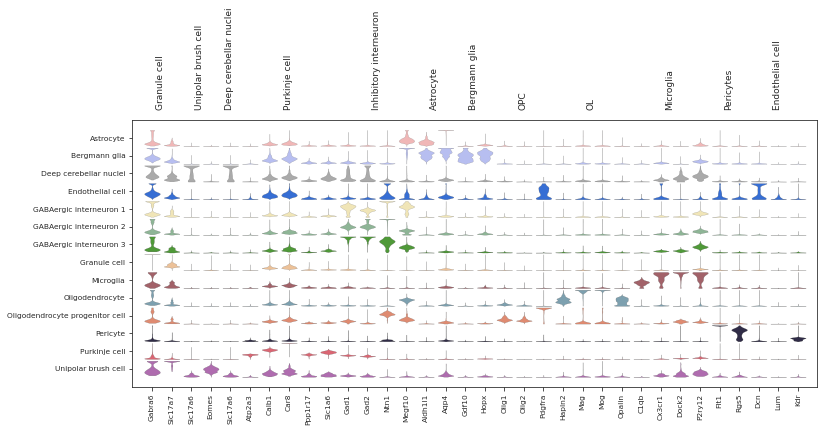

In [11]:
sc.pl.stacked_violin(adata, mousemarkers, groupby='ctype_ubcupdate', 
                     use_raw=False, standard_scale='obs',
                     row_palette=[cmap_ctype[i] for i in sorted(cmap_ctype.keys())])

# human umap

In [2]:
wt = sc.read('/home/ngr4/project/scnd/data/processed/hum_ctrl.h5ad')
mut = sc.read('/home/ngr4/project/scnd/data/processed/hum_sca1.h5ad')

In [7]:
wt

AnnData object with n_obs × n_vars = 42556 × 29179
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'leiden', 'ctype', 'subclusters', 'IN_subcluster', 'Sample', 'Condition', 'value'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'IN_subcluster_colors', 'batch_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'imputed'
    obsp: 'connectivities', 'distances'

In [8]:
mut

AnnData object with n_obs × n_vars = 35232 × 29179
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'leiden', 'ctype', 'subclusters', 'IN_subcluster', 'Sample', 'Condition', 'value'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'IN_subcluster_colors', 'batch_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'imputed'
    obsp: 'connectivities', 'distances'

In [5]:
wt.obs.groupby('batch').count()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,pmito,n_genes,leiden,ctype,subclusters,IN_subcluster,Sample,Condition,value
batch,,,,,,,,,,,,,,,,,
14,4508,4508,4508,4508,4508,4508,4508,4508,4508,4508,4508,4508,4508,4508,4508,4508,4508
409,2472,2472,2472,2472,2472,2472,2472,2472,2472,2472,2472,2472,2472,2472,2472,2472,2472
1516,9885,9885,9885,9885,9885,9885,9885,9885,9885,9885,9885,9885,9885,9885,9885,9885,9885
4092,6341,6341,6341,6341,6341,6341,6341,6341,6341,6341,6341,6341,6341,6341,6341,6341,6341
15162,19350,19350,19350,19350,19350,19350,19350,19350,19350,19350,19350,19350,19350,19350,19350,19350,19350


In [6]:
mut.obs.groupby('batch').count()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,pmito,n_genes,leiden,ctype,subclusters,IN_subcluster,Sample,Condition,value
batch,,,,,,,,,,,,,,,,,
2-Jan,2764,2764,2764,2764,2764,2764,2764,2764,2764,2764,2764,2764,2764,2764,2764,2764,2764
3-Jan,13116,13116,13116,13116,13116,13116,13116,13116,13116,13116,13116,13116,13116,13116,13116,13116,13116
1-Jan,8405,8405,8405,8405,8405,8405,8405,8405,8405,8405,8405,8405,8405,8405,8405,8405,8405
132,7427,7427,7427,7427,7427,7427,7427,7427,7427,7427,7427,7427,7427,7427,7427,7427,7427
122,3520,3520,3520,3520,3520,3520,3520,3520,3520,3520,3520,3520,3520,3520,3520,3520,3520
